In [2]:
# importing required libraries 
import tensorflow as tf 
from tensorflow.keras import Model, Input 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os 
from google_drive_downloader import GoogleDriveDownloader as gdd 
import shutil

# setting random seeds 
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# print tensorflow version
tf.__version__

'2.7.0'

In [3]:
# downloading the classification dataset from google drive 
url='https://drive.google.com/file/d/1IERfEIZ9fAyXw4cONAcX3JRVfUwAKQld/view?usp=sharing'
file_id = url.split('/')[-2]
gdd.download_file_from_google_drive(file_id=file_id, dest_path='/content/classification_dataset.zip', unzip=True)


Unzipping...Done.


In [4]:
# specifying folderpaths for train, val, test folders for poachers and no_poachers
folderpath_train = '/content/classification_dataset/train/'
folderpath_val   = '/content/classification_dataset/val/'
folderpath_test  = '/content/classification_dataset/test/'
folderpath_train_poachers   = os.path.join(folderpath_train,'poacher_images')
folderpath_train_nopoachers = os.path.join(folderpath_train,'no_poacher_images')
folderpath_val_poachers     = os.path.join(folderpath_val,'poacher_images')
folderpath_val_nopoachers   = os.path.join(folderpath_val,'no_poacher_images')
folderpath_test_poachers    = os.path.join(folderpath_test,'poacher_images')
folderpath_test_nopoachers  = os.path.join(folderpath_test,'no_poacher_images')

# printing file counts 
print(len(os.listdir(folderpath_train_poachers)), 'trainset poacher images' )
print(len(os.listdir(folderpath_train_nopoachers)), 'trainset without poacher images')
print(len(os.listdir(folderpath_val_poachers)), 'valset poacher images' )
print(len(os.listdir(folderpath_val_nopoachers)), 'valset without poacher images')
print(len(os.listdir(folderpath_test_poachers)), 'testset poacher images' )
print(len(os.listdir(folderpath_test_nopoachers)), 'testset without poacher images')


20728 trainset poacher images
20719 trainset without poacher images
1259 valset poacher images
1258 valset without poacher images
1789 testset poacher images
1789 testset without poacher images


### Defining train, val and test set generators 

In [13]:
image_size = (256, 256)
batch_size = 64

print('train_ds')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    folderpath_train,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

print('val_ds')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    folderpath_val,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

print('test_ds')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    folderpath_test,
    batch_size=batch_size,
    color_mode = 'grayscale'
)

# buffered prefetching so we can yield data from disk without having I/O becoming blocking
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

train_ds
Found 41447 files belonging to 2 classes.
val_ds
Found 2517 files belonging to 2 classes.
test_ds
Found 3578 files belonging to 2 classes.


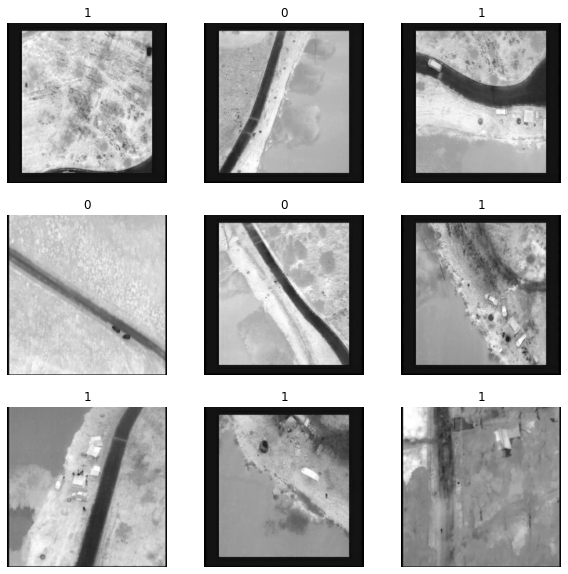

In [14]:
# visualizing the data 
# train 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

# as we can see in the plots, images with poachers are labelled as 1, images without poachers are labelled as 0

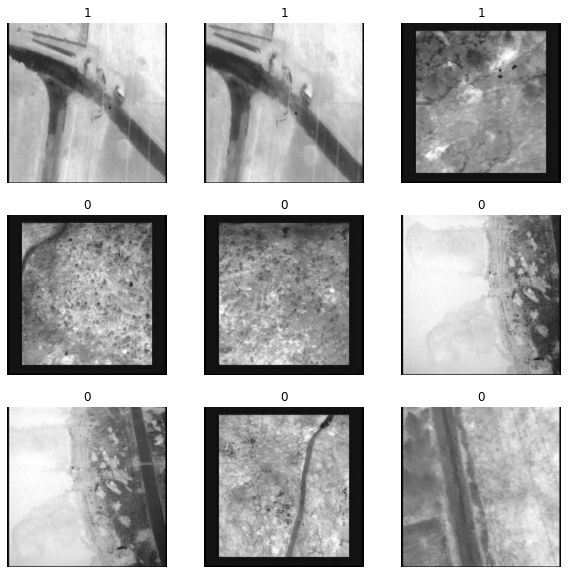

In [15]:
# visualizing the data 
# val 
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

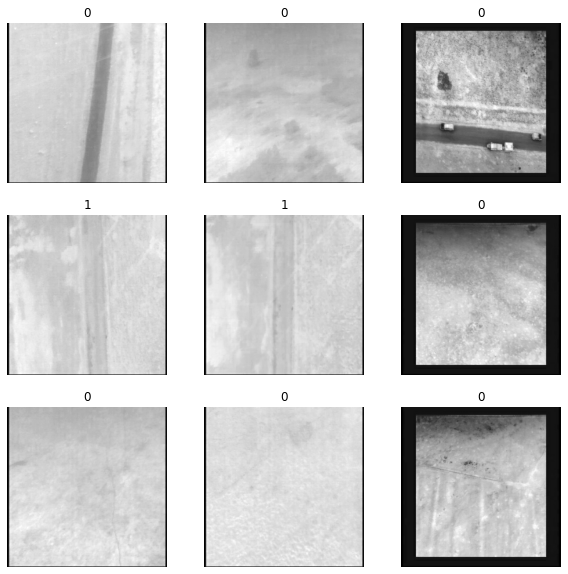

In [16]:
# visualizing the data 
# test 
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i]))
        plt.axis("off")

### Defining model architecture, optimizer settings, etc 

In [17]:
# function for defining model architecture 
def make_model(input_shape):
    input = Input(shape=input_shape)
    # a minified version of VGGNet
    x = Rescaling(1.0 / 255)(input)
    x = Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),  strides=(2,2))(x) 
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3,3), padding="valid", strides=(2,2) , activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3,3), padding="valid",  strides=(2,2) ,activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),  strides=(2,2))(x) 
    x = Dropout(0.25)(x)
    x = Conv2D(128, kernel_size=(3,3), padding="valid",  strides=(2,2) , activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3,3), padding="valid",  strides=(2,2) , activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2),  strides=(2,2))(x) 
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(input, output)
    return model

# instantiating the model
model = make_model(input_shape= image_size + (1,) )
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_7 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_8 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                           

In [18]:
# compiling the model - setting loss function, metrics and optimizer , defining callbacks 
opt  = tf.keras.optimizers.Adam(learning_rate = 1e-3)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=opt, loss=loss, metrics=metrics)


### Training the model 

In [20]:
checkpoint = ModelCheckpoint('best_model_minivgg.h5', 
                              monitor="val_accuracy", mode="max", 
                              save_weights_only=False, save_best_only=True, save_freq='epoch' , 
                              verbose=1 )
callbacks = [checkpoint]

num_epochs = 15
H = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, callbacks = callbacks)

Epoch 1/15
648/648 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9654
Epoch 00001: val_accuracy improved from -inf to 0.53119, saving model to best_model_minivgg.h5
648/648 [==============================] - 97s 150ms/step - loss: 0.0977 - accuracy: 0.9654 - val_loss: 1.6394 - val_accuracy: 0.5312
Epoch 2/15
648/648 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9793
Epoch 00002: val_accuracy improved from 0.53119 to 0.58006, saving model to best_model_minivgg.h5
648/648 [==============================] - 98s 150ms/step - loss: 0.0593 - accuracy: 0.9793 - val_loss: 3.0517 - val_accuracy: 0.5801
Epoch 3/15
648/648 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9832
Epoch 00003: val_accuracy improved from 0.58006 to 0.65197, saving model to best_model_minivgg.h5
648/648 [==============================] - 97s 150ms/step - loss: 0.0488 - accuracy: 0.9832 - val_loss: 1.9042 - val_accuracy: 0.6520
Epoch 4/15
648/648 

In [21]:
# plotting loss and accuracy curves 
plt.style.use('ggplot')
# loss plots
plt.figure()
plt.plot(np.arange(num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(num_epochs), H.history["val_loss"], label="val_loss")
plt.title("Loss Curves")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
# accuracy plots
plt.figure()
plt.plot(np.arange(num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
# evaluation on train set 
train_loss, train_accuracy = model.evaluate(train_ds)

# evaluation on val set 
val_loss, val_accuracy = model.evaluate(val_ds)

# evaluation on test set 
test_loss, test_accuracy = model.evaluate(test_ds)


56/56 [==============================] - 3s 43ms/step - loss: 6.0580 - accuracy: 0.4519


In [23]:
# printing accuracy values 
print("Custom VGGNet model")
print('train accuracy: {:.3f}'.format(train_accuracy))
print('val accuracy: {:.3f}'.format(val_accuracy))
print('test accuracy: {:.3f} '.format(test_accuracy))

Custom VGGNet model
train accuracy: 0.976
val accuracy: 0.630
test accuracy: 0.452 


In [25]:
# testing model was saved properly 
from tensorflow.keras.models import load_model 

model_filepath = '/content/best_model_minivgg.h5'
model_test = load_model(model_filepath)
#model_test.summary()
model_test.evaluate(test_ds)

56/56 [==============================] - 3s 40ms/step - loss: 5.1483 - accuracy: 0.4631


[5.148313045501709, 0.4631078839302063]

In [26]:
# saving trained model back to google drive 
# mount google drive 
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [27]:
# copy model to drive 
!cp '/content/best_model_minivgg.h5' '/content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/trained_vggnet_model_nv1.h5'